In [166]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

train = pd.read_csv('./train.csv', sep=';')
test = pd.read_csv('./test.csv', sep=';')

answer = train.cardio

complete = pd.concat([train, test])
complete = complete.drop(['id', 'cardio'], axis=1)
complete.loc[complete['active'] == 'None', 'active'] = np.NaN
complete.loc[complete['alco'] == 'None', 'alco'] = np.NaN
complete.loc[complete['smoke'] == 'None', 'smoke'] = np.NaN
complete['active'] = complete['active'].astype('float')
complete['alco'] = complete['alco'].astype('float')
complete['smoke'] = complete['smoke'].astype('float')

# age, gender, height, weight, 
# ap_hi, ap_lo, cholesterol, gluc, 
# smoke, alco, active

complete.loc[complete.ap_hi == 0, 'ap_hi'] = np.NaN
complete.loc[complete.ap_lo == 0, 'ap_lo'] = np.NaN

# Makes it worse?
# complete.loc[complete.ap_hi < 0, 'ap_hi'] *= -1
# complete.loc[complete.ap_lo < 0, 'ap_lo'] *= -1

complete.loc[complete.ap_hi > 10000, 'ap_hi'] /= 100
complete.loc[complete.ap_hi > 1000, 'ap_hi'] /= 10
complete.loc[complete.ap_hi > 300, 'ap_hi'] /= 10

complete.loc[complete.ap_hi < 2, 'ap_hi'] *= 100
complete.loc[complete.ap_hi < 25, 'ap_hi'] *= 10

complete.loc[complete.ap_lo >= 10000, 'ap_lo'] /= 100
complete.loc[complete.ap_lo >= 4000, 'ap_lo'] /= 100
complete.loc[complete.ap_lo >= 570, 'ap_lo'] /= 10

complete.loc[complete.ap_lo < 2, 'ap_lo'] *= 100
complete.loc[complete.ap_lo <= 20, 'ap_lo'] *= 10

complete.loc[complete.ap_hi < complete.ap_lo, ['ap_hi', 'ap_lo']] = complete[complete.ap_hi < complete.ap_lo][['ap_lo', 'ap_hi']]

complete['body_mass_index'] = complete['weight'] / ((complete['height'] / 100) ** 2)
complete['years'] = (complete['age'] / 365).astype('int')
complete['ap_hi_norm'] = 102 + 0.6 * complete['years']
complete['ap_lo_norm'] = 63 + 0.5 * complete['years']
complete['ap_hi_diff'] = complete['ap_hi'] - complete['ap_hi_norm']
complete['ap_lo_diff'] = complete['ap_lo'] - complete['ap_lo_norm']


complete['ap_rel'] = complete['ap_hi'] / complete['ap_lo']
complete['old'] = complete['years'] > 50

complete['underweight'] = complete['body_mass_index'] <= 18.5
complete['normal'] = (complete['body_mass_index'] > 18.5) & (complete['body_mass_index'] < 25.0)
complete['overweight'] = (complete['body_mass_index'] >= 25.0) & (complete['body_mass_index'] < 30.0)
complete['obese'] = complete['body_mass_index'] > 30.0

complete['ap_diff'] = complete['ap_hi'] - complete['ap_lo']
complete['hypertonia'] = (complete['ap_lo_diff'] > 10) & (complete['ap_hi_diff'] > 10)
complete['hipotonia'] = (complete['ap_lo_diff'] < -10) & (complete['ap_hi_diff'] < -10)
complete['born_heart_condition'] = (complete['years'] < 42) & (complete['hipotonia']) & (complete['active'] == 0) & (complete['underweight'] == 1)

train = complete.head(len(train))
test = complete.tail(len(test))

from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.model_selection import cross_val_predict, learning_curve

model = XGBClassifier()
print model
predictions = cross_val_predict(model, train, answer, cv=5)
proba_predictions = cross_val_predict(model, train, answer, cv=5, method='predict_proba')

print log_loss(answer, proba_predictions)
print accuracy_score(answer, predictions)
print classification_report(answer, predictions)

# train_sizes, train_scores, test_scores = learning_curve(model, train, answer, cv=5)

# data = { 'x': train_sizes, 'y': map(lambda x: np.mean(x), train_scores) }
# sns.pointplot(x='x', y='y', data=data)

# data = { 'x': train_sizes, 'y': map(lambda x: np.mean(x), test_scores) }
# sns.pointplot(x='x', y='y', data=data, color='red')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
0.539537948019
0.736428571429
             precision    recall  f1-score   support

          0       0.72      0.78      0.75     35021
          1       0.76      0.70      0.73     34979

avg / total       0.74      0.74      0.74     70000



In [117]:
train['predicted'] = predictions
train['expected'] = answer
train['probas'] = proba_predictions[:, 1]
train['loss'] = - ((answer * np.log(proba_predictions[:, 1]) + (1 - answer) * np.log(1 - proba_predictions[:, 1])) / len(answer))
errors = train[train['predicted'] != train['expected']]
# sns.pairplot(errors[['ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'age', 'weight', 'gender', 'height', 'body_mass_index', 'expected', 'predicted', 'probas']], markers='+', hue='expected', plot_kws={'s': 1}, size=4)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

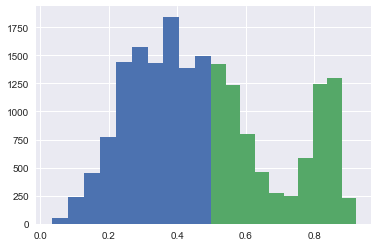

In [126]:
errors.sort_values('loss', ascending=False)
errors[errors.predicted == 0].probas.hist()
errors[errors.predicted == 1].probas.hist()

In [143]:
import time

model.fit(train, answer)
proba_predictions = model.predict_proba(test)

submission_response = pd.DataFrame({
    'y': proba_predictions[:,1]
})

timestr = time.strftime("%Y%m%d_%H%M")
pd.DataFrame(submission_response).to_csv('./outputs/naive.' + timestr + '.csv', header=False, index=False, line_terminator="\n")
pd.DataFrame(submission_response).to_csv('./outputs/_naive.latest.csv', header=False, index=False, line_terminator="\n")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
train['cardio'] = answer

sns.pairplot(train[['ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'age', 'weight', 'gender', 'height', 'body_mass_index', 'cardio']], markers='+', hue='cardio', plot_kws={'s': 1}, size=5)

# def plot_boxes(cols, dato):
#     return map(lambda x: sns.boxplot(x='answer', y=x, data=dato, ax=plt.figure().add_subplot(111)), cols)

# [
#     sns.pairplot(knn_report[knn_report['predicted'] == knn_report['expected']], hue='expected', markers='+', plot_kws={'s': 1 }),
#     sns.pairplot(rr_report[rr_report['predicted'] == rr_report['expected']], hue='expected', markers='+', plot_kws={'s': 1 })
# ]

In [151]:
len(train)

18186

In [158]:
train['']

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,smoke,weight,body_mass_index,years,ap_hi_norm,ap_lo_norm,ap_hi_diff,ap_lo_diff,hypertonia,hipotonia,ap_rel,old,underweight,normal,overweight,obese,born_heart_condition,cardio
27305,0.0,14328,0.0,100.0,70.0,2,2,1,183,0.0,59.0,17.617725,39,125.4,82.5,-25.4,-12.5,False,True,1.428571,False,True,False,False,False,True,0
30656,0.0,14492,0.0,110.0,70.0,1,2,2,180,0.0,53.0,16.358025,39,125.4,82.5,-15.4,-12.5,False,True,1.571429,False,True,False,False,False,True,0
35427,0.0,14450,0.0,110.0,60.0,2,1,2,158,0.0,43.0,17.224804,39,125.4,82.5,-15.4,-22.5,False,True,1.833333,False,True,False,False,False,True,0
37199,0.0,14530,0.0,110.0,70.0,1,2,1,152,0.0,40.0,17.313019,39,125.4,82.5,-15.4,-12.5,False,True,1.571429,False,True,False,False,False,True,0
38513,0.0,15178,0.0,110.0,70.0,1,1,1,165,0.0,50.0,18.365473,41,126.6,83.5,-16.6,-13.5,False,True,1.571429,False,True,False,False,False,True,0
41727,0.0,14568,0.0,80.0,50.0,1,1,1,161,0.0,46.0,17.746229,39,125.4,82.5,-45.4,-32.5,False,True,1.600000,False,True,False,False,False,True,0
